# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

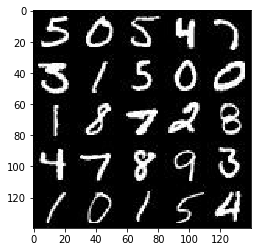

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

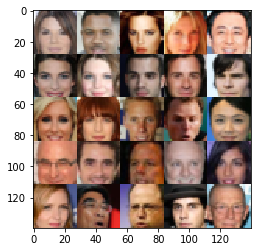

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [55]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [56]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 14x14x64
        
        x2 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(inputs=relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        ## Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_depth = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps=0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                    if steps % show_every == 0:
                        show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                        
        saver.save(sess, './generator.ckpt')
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1580... Generator Loss: 0.0541
Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 5.9339
Epoch 1/2... Discriminator Loss: 2.9518... Generator Loss: 0.1616
Epoch 1/2... Discriminator Loss: 0.2621... Generator Loss: 2.4555
Epoch 1/2... Discriminator Loss: 0.1270... Generator Loss: 2.9163
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 1.7080
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 3.4544
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 2.9071
Epoch 1/2... Discriminator Loss: 2.9424... Generator Loss: 5.7738
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 1.9613


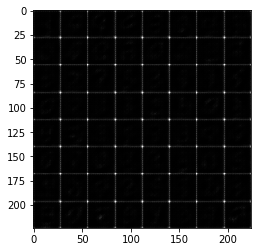

Epoch 1/2... Discriminator Loss: 0.2805... Generator Loss: 2.0707
Epoch 1/2... Discriminator Loss: 0.1532... Generator Loss: 2.7426
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 0.2394... Generator Loss: 2.0286
Epoch 1/2... Discriminator Loss: 0.1150... Generator Loss: 4.0286
Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 7.8633
Epoch 1/2... Discriminator Loss: 0.0437... Generator Loss: 5.7229
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 7.0342
Epoch 1/2... Discriminator Loss: 0.0308... Generator Loss: 7.0827
Epoch 1/2... Discriminator Loss: 0.2056... Generator Loss: 2.3804


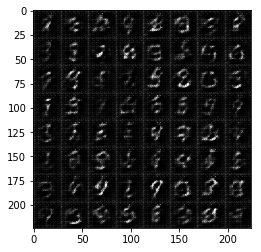

Epoch 1/2... Discriminator Loss: 0.0202... Generator Loss: 14.3765
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 0.0969... Generator Loss: 3.4026
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 0.6700... Generator Loss: 3.6722
Epoch 1/2... Discriminator Loss: 0.1727... Generator Loss: 4.7578
Epoch 1/2... Discriminator Loss: 0.0271... Generator Loss: 9.6197
Epoch 1/2... Discriminator Loss: 0.1903... Generator Loss: 2.6551
Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 1.1094
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 0.8874


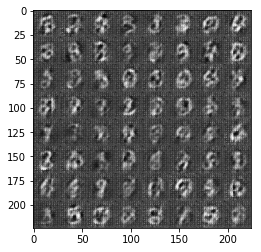

Epoch 1/2... Discriminator Loss: 0.1484... Generator Loss: 2.8202
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 0.2427... Generator Loss: 5.8518
Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.3699
Epoch 1/2... Discriminator Loss: 0.4719... Generator Loss: 1.5282
Epoch 1/2... Discriminator Loss: 0.2608... Generator Loss: 2.0987
Epoch 1/2... Discriminator Loss: 0.3071... Generator Loss: 1.9721
Epoch 1/2... Discriminator Loss: 0.1701... Generator Loss: 2.6360
Epoch 1/2... Discriminator Loss: 0.1945... Generator Loss: 2.2010


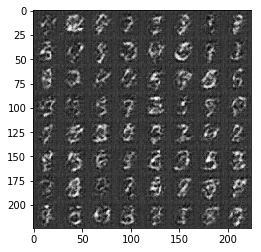

Epoch 1/2... Discriminator Loss: 0.1503... Generator Loss: 2.2713
Epoch 1/2... Discriminator Loss: 0.0897... Generator Loss: 3.3685
Epoch 1/2... Discriminator Loss: 0.0534... Generator Loss: 3.6965
Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 5.7553
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 2.8707
Epoch 1/2... Discriminator Loss: 0.2605... Generator Loss: 2.0582
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 1.8817
Epoch 1/2... Discriminator Loss: 0.2148... Generator Loss: 2.1177


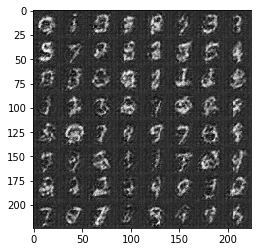

Epoch 1/2... Discriminator Loss: 0.1107... Generator Loss: 2.7736
Epoch 1/2... Discriminator Loss: 0.0468... Generator Loss: 3.8188
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 0.5146... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 1.4756
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 1.4455
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 1.7148
Epoch 1/2... Discriminator Loss: 0.2827... Generator Loss: 1.7680


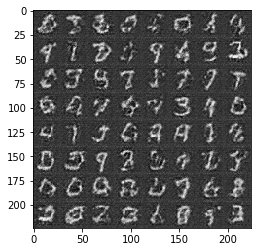

Epoch 1/2... Discriminator Loss: 0.0301... Generator Loss: 5.1337
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 2.0593
Epoch 1/2... Discriminator Loss: 0.2726... Generator Loss: 1.9164
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 1.3075
Epoch 1/2... Discriminator Loss: 0.1509... Generator Loss: 2.3027
Epoch 1/2... Discriminator Loss: 0.0104... Generator Loss: 7.1022
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 0.0395... Generator Loss: 3.8043
Epoch 1/2... Discriminator Loss: 0.0523... Generator Loss: 3.6359
Epoch 1/2... Discriminator Loss: 0.0447... Generator Loss: 7.4309


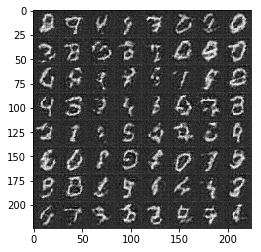

Epoch 1/2... Discriminator Loss: 0.0073... Generator Loss: 6.0123
Epoch 1/2... Discriminator Loss: 0.0179... Generator Loss: 10.5007
Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 2.6421
Epoch 1/2... Discriminator Loss: 0.0041... Generator Loss: 13.5862
Epoch 1/2... Discriminator Loss: 0.0469... Generator Loss: 3.7303
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 10.1530
Epoch 1/2... Discriminator Loss: 0.0101... Generator Loss: 5.3653
Epoch 1/2... Discriminator Loss: 0.0083... Generator Loss: 9.4715
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 6.3844
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.1165


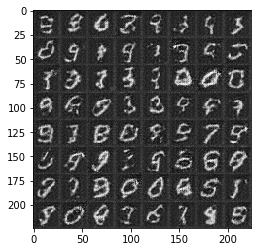

Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 0.6509... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 1.1975
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 1.7415
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 1.8571
Epoch 1/2... Discriminator Loss: 1.7422... Generator Loss: 3.8483
Epoch 1/2... Discriminator Loss: 0.4098... Generator Loss: 1.4779
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 4.8130
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 5.5096
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 2.0678


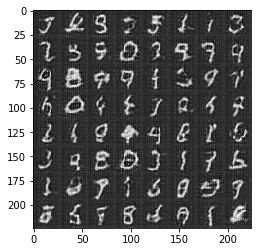

Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 6.8196
Epoch 1/2... Discriminator Loss: 0.1232... Generator Loss: 4.6245
Epoch 1/2... Discriminator Loss: 0.0095... Generator Loss: 13.8335
Epoch 2/2... Discriminator Loss: 0.0268... Generator Loss: 5.7679
Epoch 2/2... Discriminator Loss: 0.0144... Generator Loss: 6.1483
Epoch 2/2... Discriminator Loss: 3.0791... Generator Loss: 10.5617
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 2.5855
Epoch 2/2... Discriminator Loss: 0.0771... Generator Loss: 2.9763
Epoch 2/2... Discriminator Loss: 0.1807... Generator Loss: 4.1010


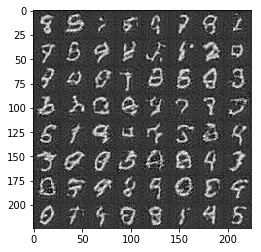

Epoch 2/2... Discriminator Loss: 0.0234... Generator Loss: 4.6047
Epoch 2/2... Discriminator Loss: 0.1435... Generator Loss: 2.3622
Epoch 2/2... Discriminator Loss: 0.0705... Generator Loss: 3.1228
Epoch 2/2... Discriminator Loss: 0.0101... Generator Loss: 9.7427
Epoch 2/2... Discriminator Loss: 0.0067... Generator Loss: 6.9537
Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 6.5928
Epoch 2/2... Discriminator Loss: 0.0643... Generator Loss: 3.4478
Epoch 2/2... Discriminator Loss: 0.0033... Generator Loss: 12.8061
Epoch 2/2... Discriminator Loss: 0.0713... Generator Loss: 2.9939
Epoch 2/2... Discriminator Loss: 0.1002... Generator Loss: 2.8884


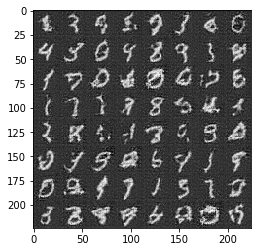

Epoch 2/2... Discriminator Loss: 0.0988... Generator Loss: 2.7196
Epoch 2/2... Discriminator Loss: 0.0022... Generator Loss: 15.8706
Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 8.9156
Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 7.5559
Epoch 2/2... Discriminator Loss: 0.0058... Generator Loss: 9.3645
Epoch 2/2... Discriminator Loss: 0.0058... Generator Loss: 7.8888
Epoch 2/2... Discriminator Loss: 0.0028... Generator Loss: 17.0208
Epoch 2/2... Discriminator Loss: 0.0042... Generator Loss: 6.1037
Epoch 2/2... Discriminator Loss: 0.0843... Generator Loss: 3.3815
Epoch 2/2... Discriminator Loss: 0.0187... Generator Loss: 4.5345


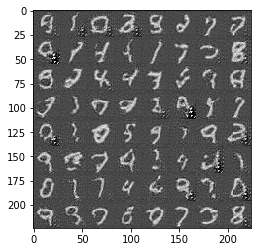

Epoch 2/2... Discriminator Loss: 0.0108... Generator Loss: 5.1660
Epoch 2/2... Discriminator Loss: 0.0059... Generator Loss: 6.7160
Epoch 2/2... Discriminator Loss: 0.0052... Generator Loss: 8.2808
Epoch 2/2... Discriminator Loss: 0.0028... Generator Loss: 10.0124
Epoch 2/2... Discriminator Loss: 0.0096... Generator Loss: 5.4411
Epoch 2/2... Discriminator Loss: 0.0264... Generator Loss: 7.4044
Epoch 2/2... Discriminator Loss: 0.0036... Generator Loss: 15.9139
Epoch 2/2... Discriminator Loss: 0.0239... Generator Loss: 4.2516
Epoch 2/2... Discriminator Loss: 0.0744... Generator Loss: 10.0943
Epoch 2/2... Discriminator Loss: 0.0027... Generator Loss: 8.6729


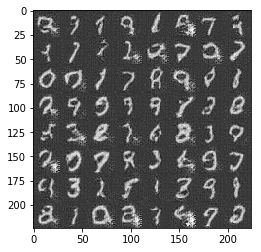

Epoch 2/2... Discriminator Loss: 0.0223... Generator Loss: 4.9131
Epoch 2/2... Discriminator Loss: 0.0040... Generator Loss: 14.6099
Epoch 2/2... Discriminator Loss: 0.0101... Generator Loss: 5.7278
Epoch 2/2... Discriminator Loss: 0.0048... Generator Loss: 14.3037
Epoch 2/2... Discriminator Loss: 0.0065... Generator Loss: 6.1921
Epoch 2/2... Discriminator Loss: 0.0069... Generator Loss: 7.5846
Epoch 2/2... Discriminator Loss: 0.0063... Generator Loss: 8.6700
Epoch 2/2... Discriminator Loss: 0.0734... Generator Loss: 3.2806
Epoch 2/2... Discriminator Loss: 0.0238... Generator Loss: 7.0444
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 2.1020


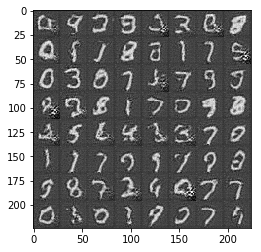

Epoch 2/2... Discriminator Loss: 1.4899... Generator Loss: 2.0499
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 2.0324
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 3.1540
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.9729


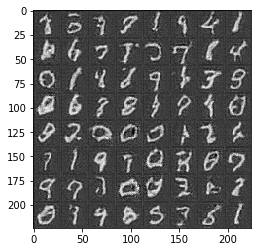

Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 2.2159
Epoch 2/2... Discriminator Loss: 2.0082... Generator Loss: 0.2129
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 2.4231
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.2857
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.5050
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 3.1501
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 1.1708


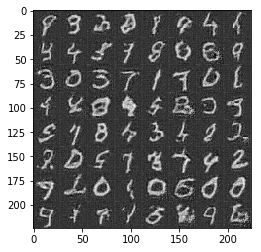

Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 1.4618
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 1.2298
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6324
Epoch 2/2... Discriminator Loss: 0.3540... Generator Loss: 2.1219
Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 2.0816


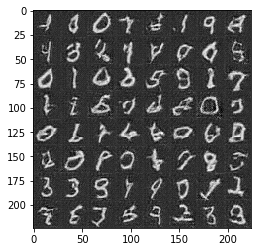

Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 3.2537
Epoch 2/2... Discriminator Loss: 0.4211... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 1.9793... Generator Loss: 0.2313
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 2.4596
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 2.3776
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.8639
Epoch 2/2... Discriminator Loss: 1.9584... Generator Loss: 0.2475
Epoch 2/2... Discriminator Loss: 0.5196... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 0.3275... Generator Loss: 2.4908


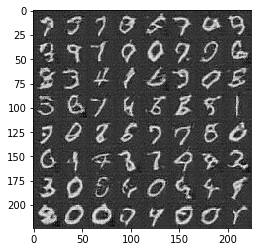

Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 2.0914
Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 6.9935
Epoch 2/2... Discriminator Loss: 0.2891... Generator Loss: 1.8165
Epoch 2/2... Discriminator Loss: 0.2672... Generator Loss: 1.9331
Epoch 2/2... Discriminator Loss: 4.1986... Generator Loss: 0.0302


In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

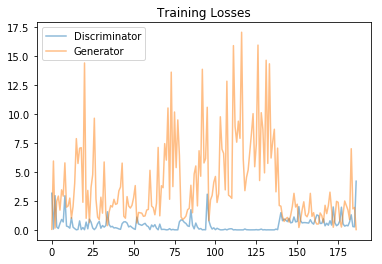

In [66]:
fig, ax = pyplot.subplots()
losses_mnist = np.array(losses_mnist)
pyplot.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 2.9731
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 12.7737
Epoch 1/1... Discriminator Loss: 0.2108... Generator Loss: 7.1135
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.3501
Epoch 1/1... Discriminator Loss: 0.0350... Generator Loss: 4.6439
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 2.8770
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.4556


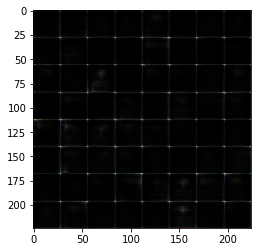

Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 6.1067
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 0.0911... Generator Loss: 3.3327
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 8.1671
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 10.3799
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 3.0712
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 8.8811
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 6.3279
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 3.2429
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.8021


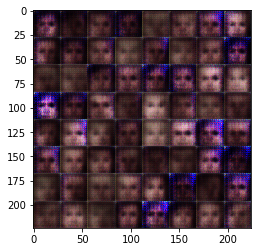

Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 7.9940
Epoch 1/1... Discriminator Loss: 0.2685... Generator Loss: 4.8920
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 4.5162
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 2.1783
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 2.6255
Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 3.4412
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 4.6063
Epoch 1/1... Discriminator Loss: 0.0335... Generator Loss: 8.0023
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 7.6741


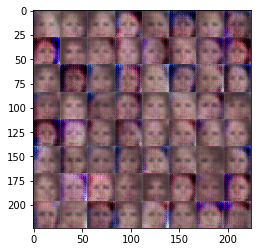

Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 9.0632
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 3.4457
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 6.4061
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 3.9441
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.8537
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 2.6220
Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 5.7417
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 3.4833
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 3.1895


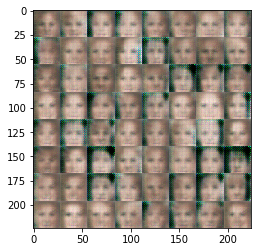

Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 5.0186
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 7.1941
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 5.5592
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 4.5790
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 3.2564
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 3.4272
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.3705


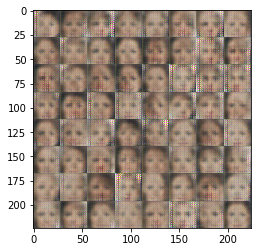

Epoch 1/1... Discriminator Loss: 0.3018... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.5158
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.2592
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 7.6871
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 5.2365
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 2.6495
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.2793


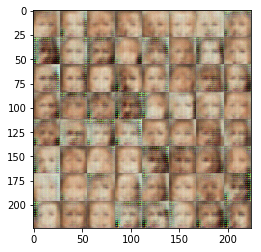

Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 3.6910
Epoch 1/1... Discriminator Loss: 0.2547... Generator Loss: 3.8894
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 4.6714
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 2.3606
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8925


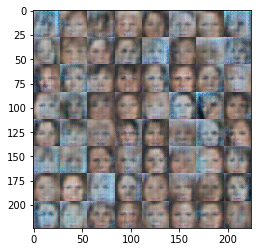

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 2.7208
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 3.0050
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.5228


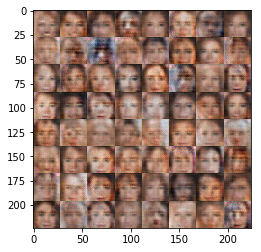

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.7143
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4529


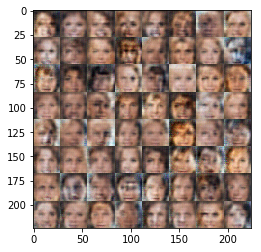

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.8020


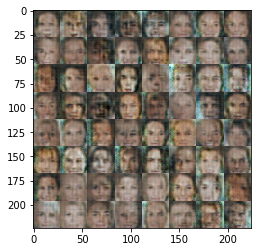

Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.2761
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 1.8807... Generator Loss: 0.2797
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 1.8462


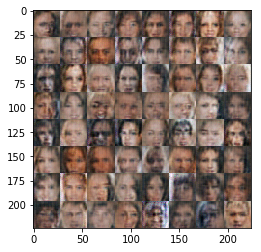

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 3.2452... Generator Loss: 4.4912
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8508


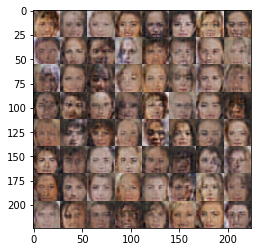

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.9223... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.9515... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.5021


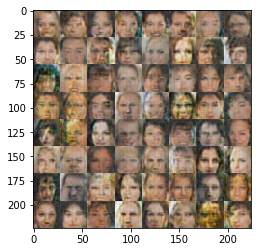

Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.3340


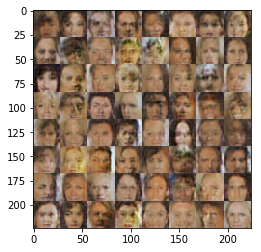

Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.2712
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.3406
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.3513


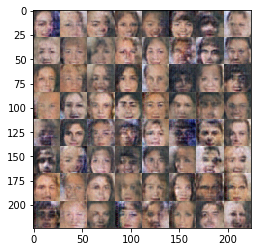

Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 2.4516... Generator Loss: 0.1103
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.6396


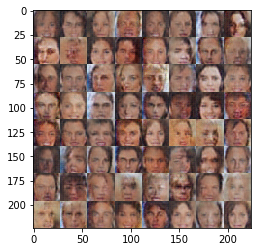

Epoch 1/1... Discriminator Loss: 1.9903... Generator Loss: 0.1867
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 2.6093
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9533


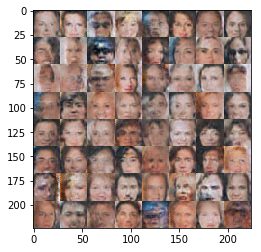

Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.4746
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 1.8978... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 2.3673


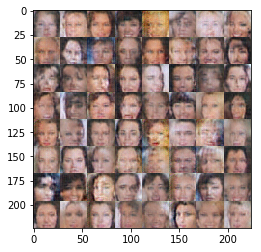

Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.6442... Generator Loss: 0.2991
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.9484... Generator Loss: 0.2270


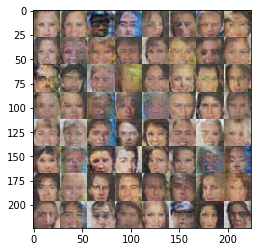

Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.3113
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.8959... Generator Loss: 0.2122
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.0202


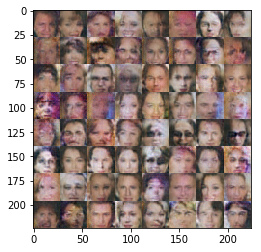

Epoch 1/1... Discriminator Loss: 1.8110... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.4829


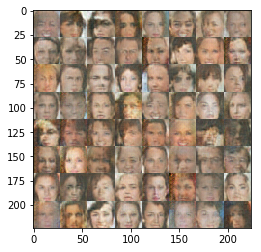

Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.4116
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9893


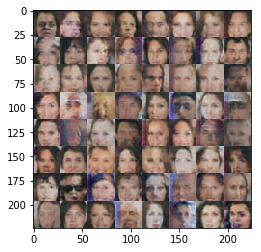

Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.5368


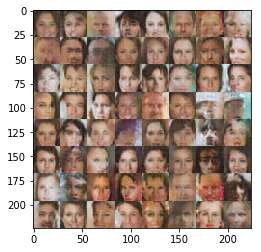

Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6377


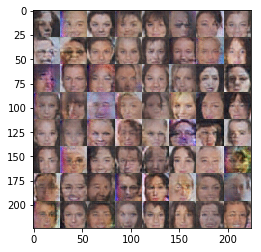

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 2.0094
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.2458
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.4562


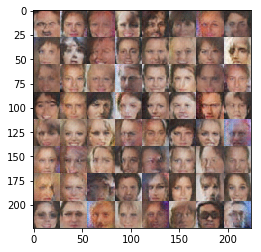

Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 2.8244
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.8674... Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 1.8571... Generator Loss: 0.2507
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 1.0905


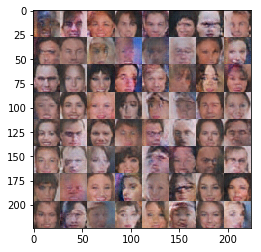

Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5047


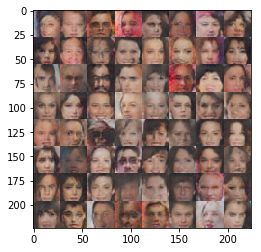

Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.7553... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 2.1012... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.3725


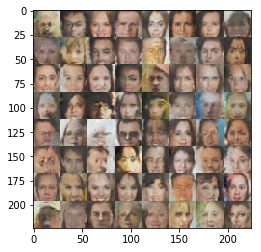

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.4958


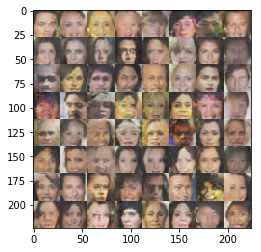

Epoch 1/1... Discriminator Loss: 2.0311... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 1.7330... Generator Loss: 0.2694
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.7392... Generator Loss: 0.2563


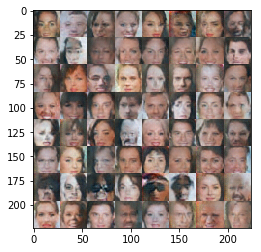

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.3945


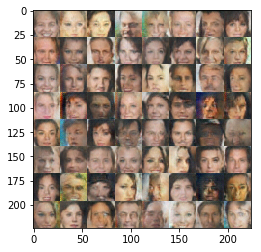

Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 1.9418... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.4171


In [64]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

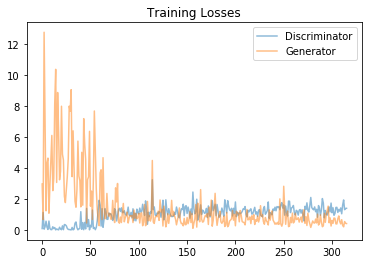

In [65]:
fig, ax = pyplot.subplots()
losses_celeba = np.array(losses_celeba)
pyplot.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.